In [ ]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model

import seaborn as sns


time: 1.92 s (started: 2021-05-26 14:48:10 +00:00)


In [ ]:
# from tensorflow.keras import mixed_precision

# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

time: 692 µs (started: 2021-05-26 14:48:12 +00:00)


In [ ]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'cifar10',
    data_dir = "/content/drive/MyDrive/Colab Notebooks/Datasets/TensorflowDatasets",
    split=['train[:80%]', 'train[80%:]', 'test'],
    
    with_info=True,
    as_supervised=True
)

time: 672 ms (started: 2021-05-26 14:48:12 +00:00)


In [ ]:
print(ds_info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)

time: 5.14 ms (started: 2021-05-26 14:48:13 +00:00)


In [ ]:
print(type(ds_train))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
time: 1.95 ms (started: 2021-05-26 14:48:13 +00:00)


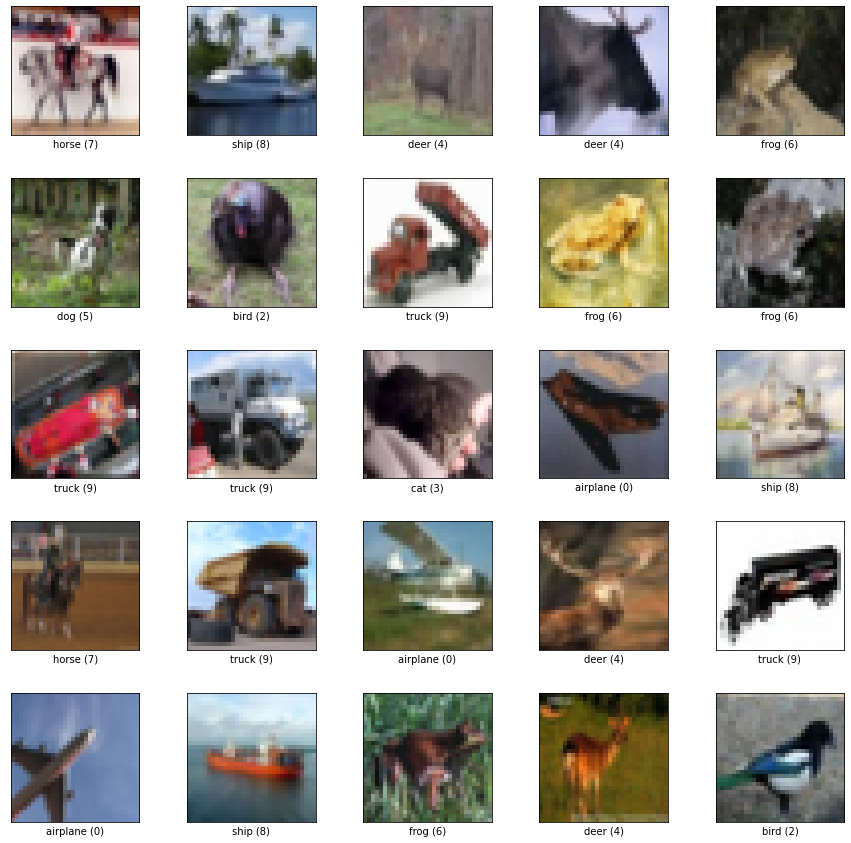

time: 1.03 s (started: 2021-05-26 14:48:13 +00:00)


In [ ]:
fig = tfds.show_examples(ds_train, ds_info, rows = 5, cols = 5)

In [ ]:
img_height = img_width = 128

print(img_height)
print(img_width)

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 64



128
128
time: 2.33 ms (started: 2021-05-26 14:48:14 +00:00)


In [ ]:
def downscale_img(image, label):
  image = tf.image.resize(image, [img_height, img_width])
  # image = tf.reshape(-1,img_height*img_width)
  return image, label



ds_train = ds_train.map(downscale_img, num_parallel_calls=AUTOTUNE)
ds_val = ds_val.map(downscale_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.map(downscale_img, num_parallel_calls=AUTOTUNE)


time: 91.7 ms (started: 2021-05-26 14:48:14 +00:00)


In [ ]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

def configure_for_performance(ds):
    ds = ds.map(normalize_img, num_parallel_calls = AUTOTUNE)
    # ds = ds.cache("Cache")
    ds = ds.shuffle(buffer_size=256)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


def configure_for_performance_3(ds):
    ds = ds.map(normalize_img, num_parallel_calls = AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

time: 8.65 ms (started: 2021-05-26 14:48:14 +00:00)


In [ ]:
ds_train = configure_for_performance(ds_train)
ds_val = configure_for_performance_3(ds_val)
ds_test = configure_for_performance_3(ds_test)


time: 54 ms (started: 2021-05-26 14:48:14 +00:00)


In [ ]:
for image, label in ds_train.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

for image, label in ds_val.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
    
for image, label in ds_test.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())


Image shape:  (64, 128, 128, 3)
Label:  [9 6 7 9 1 8 3 9 0 9 0 3 0 6 1 7 0 1 8 3 8 1 7 7 8 2 4 3 4 4 3 9 9 2 1 0 3
 1 3 5 8 8 4 4 3 5 7 6 0 6 2 8 0 2 4 9 5 8 5 8 8 5 1 9]
Image shape:  (64, 128, 128, 3)
Label:  [4 0 4 7 6 6 6 0 2 8 4 0 8 7 9 5 5 0 1 6 5 6 6 6 2 8 8 3 1 3 2 7 5 5 1 4 5
 1 2 2 3 1 3 0 0 7 5 1 2 5 8 2 5 8 1 3 7 3 6 4 6 9 2 4]
Image shape:  (64, 128, 128, 3)
Label:  [7 0 6 9 5 1 7 0 3 2 7 2 7 9 6 8 8 8 7 9 4 2 3 5 0 0 2 8 1 8 2 0 7 2 0 0 9
 1 0 5 1 5 0 3 5 0 2 0 5 3 7 4 1 4 2 5 1 5 2 0 7 2 2 1]
time: 548 ms (started: 2021-05-26 14:48:14 +00:00)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

num_classes = ds_info.features["label"].num_classes

path = '/content/drive/MyDrive/Colab Notebooks/Notebooks/Models/Final/ES_MobileNet_Cifar10/' #_Relu_L2_Regularizer_Dropout/'

def model_plot(model_history, p, t):


  img_path = p + t + ".png" 


  pd.DataFrame(model_history.history).plot(figsize=(16, 10))
  plt.grid(True)
  plt.gca().set_ylim(0, 1.2)
  plt.title(t)
  plt.savefig(img_path)
  plt.show()
  



time: 10.4 ms (started: 2021-05-26 14:48:15 +00:00)


In [ ]:
last_layers = 1
dropout = 1.0

n = last_layers
d = dropout
layer = 2


time: 2.22 ms (started: 2021-05-26 14:48:15 +00:00)


In [ ]:
# Creating model
base_model = tf.keras.applications.MobileNet(
    include_top=False, input_shape=(img_height, img_width, 3),
    classes=num_classes, dropout=d, weights='imagenet')

b = -n

m = base_model.layers[b].output

m = layers.GlobalAveragePooling2D()(m)



# output layer
predictions = layers.Dense(num_classes, activation="softmax")(m)

base_model = Model(inputs = base_model.input, outputs = predictions)

base_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32)        0     

L1
L2
Epoch 1/30
625/625 [==============================] - 54s 79ms/step - loss: 38.0610 - accuracy: 0.7752 - val_loss: 21.1895 - val_accuracy: 0.8962
Epoch 2/30
625/625 [==============================] - 47s 76ms/step - loss: 12.3548 - accuracy: 0.9147 - val_loss: 6.1863 - val_accuracy: 0.9172
Epoch 3/30
625/625 [==============================] - 47s 76ms/step - loss: 3.4813 - accuracy: 0.9416 - val_loss: 1.8108 - val_accuracy: 0.9279
Epoch 4/30
625/625 [==============================] - 48s 76ms/step - loss: 1.0888 - accuracy: 0.9595 - val_loss: 0.7284 - val_accuracy: 0.9320
Epoch 5/30
625/625 [==============================] - 47s 76ms/step - loss: 0.4837 - accuracy: 0.9730 - val_loss: 0.4555 - val_accuracy: 0.9372
Epoch 6/30
625/625 [==============================] - 48s 76ms/step - loss: 0.3085 - accuracy: 0.9814 - val_loss: 0.3649 - val_accuracy: 0.9412
Epoch 7/30
625/625 [==============================] - 47s 75ms/step - loss: 0.2372 - accuracy: 0.9876 - val_loss: 0.3302 - val_

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Notebooks/Models/Final/ES_MobileNet_Cifar10/moled_HL_512/assets


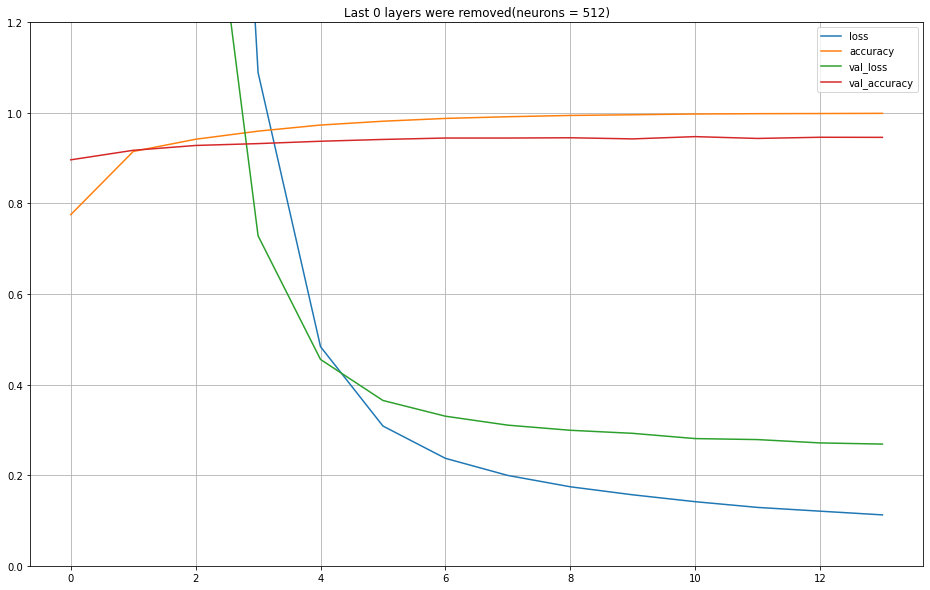

157/157 [==============================] - 4s 25ms/step - loss: 0.2915 - accuracy: 0.9417
Last 0 layers were removed
Test Accuracy: 94.170%
Loss: 0.292%



time: 15min 22s (started: 2021-05-26 14:48:15 +00:00)


In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax


activation_funcntion = 'relu'
af = activation_funcntion
regularizer_rate = 0.05

# neurons = [256, 512]
neurons = [512]

for i in range(len(neurons)):
  
  model = base_model
  b = -(n+1)

  x = model.layers[b].output


  if layer >= 1:
    x = layers.Dense(neurons[i], activation = af,
                     kernel_regularizer=regularizers.L2(regularizer_rate)
                    )(x)
    print("L1")

    if layer >= 2:
      x = layers.Dense(neurons[i], activation = af,
                       kernel_regularizer=regularizers.L2(regularizer_rate)
                      )(x)
      x = layers.Dropout(0.2)(x)
      print("L2")
      

  predictions2 = layers.Dense(num_classes, activation="softmax")(x)

  model = Model(inputs = model.input, outputs = predictions2)

  # model.summary()


  # Model compilation
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adamax(0.0001),
                metrics=['accuracy'])


  callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                            patience=3, restore_best_weights=True)

  # Training model
  model_history = model.fit(ds_train,
                            epochs=30,
                            validation_data=ds_val,
                            callbacks=[callback],
                            verbose=1)


  save_path = path + 'moled_HL_' + str(neurons[i])

  model.save(save_path)

  s = "Last " + str(n-1) + " layers were removed(neurons = " + str(neurons[i]) + ")"

  model_plot(model_history, path, s)

  loss_value, acc = model.evaluate(ds_test)

  print(f"Last {(n-1)} layers were removed")
  print(f"Test Accuracy: {(acc*100):.3f}%")
  print(f"Loss: {loss_value:.3f}%")
  
  print("\n\n")